# Setup

In [1]:
import os
import sys
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
print(sys.path)
from utils.helper_functions import SupportMaterial

# Paths to results and ground‐truths
SM_CAUSES = SupportMaterial("causes", "small")
SM_ACADEMIC_WRITING = SupportMaterial("academic_writing", "small")
SM_CAUSES_LARGE = SupportMaterial("causes", "large")
SM_ACADEMIC_WRITING_LARGE = SupportMaterial("academic_writing", "large")

EVAL_FILES_SMALL = {
    "drag_causes": SM_CAUSES.filePath_eval_drag,
    "drag_academic_writing": SM_ACADEMIC_WRITING.filePath_eval_drag,
    "iter_drag_causes": SM_CAUSES.filePath_eval_iter_drag,
    "iter_drag_academic_writing": SM_ACADEMIC_WRITING.filePath_eval_iter_drag
}
EVAL_FILES_LARGE = {
    "drag_causes": SM_CAUSES_LARGE.filePath_eval_drag,
    "drag_academic_writing": SM_ACADEMIC_WRITING_LARGE.filePath_eval_drag,
    "iter_drag_causes": SM_CAUSES_LARGE.filePath_eval_iter_drag,
    "iter_drag_academic_writing": SM_ACADEMIC_WRITING_LARGE.filePath_eval_iter_drag
}

METRICS = {
    "exact_match": "Exact Match",
    "f1": "F1 Score",
    "accuracy": "Accuracy",
    "bleu": "BLEU",
    "rouge_l": "ROUGE-L",
    "meteor": "METEOR",
    "bert_score": "BERT Score",
    "confidence": "Confidence",
    "context_length": "Context Length"
}

['/home/nlplab/atwolin/miniconda3/envs/env-thesis-conda/lib/python310.zip', '/home/nlplab/atwolin/miniconda3/envs/env-thesis-conda/lib/python3.10', '/home/nlplab/atwolin/miniconda3/envs/env-thesis-conda/lib/python3.10/lib-dynload', '', '/home/nlplab/atwolin/miniconda3/envs/env-thesis-conda/lib/python3.10/site-packages', '/home/nlplab/atwolin/thesis/code/process']


/home/nlplab/atwolin/miniconda3/envs/env-thesis-conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def transform_eval_data(data, rag_type):
    """
    Transforms the evaluation data into a DataFrame suitable for analysis.
    Supports two types of performance keys:
     1) perf["metric"]["mean"]
     2) perf["avg_metric"]
    """
    records = []
    for payload in data:
        for exp_name, exp in payload.items():
            # performance key: drag_performance or iter_drag_performance
            perf = exp.get("drag_performance") or exp.get("iter_drag_performance", {})
            # Try nested dict first, then fall back to avg_xxx
            def get_mean(metric):
                v = perf.get(metric)
                if isinstance(v, dict):
                    return v.get("mean", 0.0)
                # Mapping table for avg_ prefixes
                avg_map = {
                    "context_length": "avg_context_length",
                    "confidence":     "avg_confidence"
                }
                return perf.get(avg_map.get(metric, ""), 0.0)

            records.append({
                "rag_type":        rag_type,
                "topic":           exp.get("topic_name", exp_name.split("_")[0]),
                "rag_topic":       ' '.join(exp.get("topic_name", exp_name.split("_")[0]).split('_')).capitalize() + " - " + \
                                   rag_type,
                "chunk_size":      exp["rag_config"]["max_doc_length"],
                "num_documents":   exp["rag_config"]["num_documents"],
                "num_shots":       exp["rag_config"]["num_shots"],
                "max_iterations":  exp["rag_config"]["max_iterations"],
                "exact_match":     get_mean("exact_match"),
                "f1":              get_mean("f1"),
                "accuracy":        get_mean("accuracy"),
                "bleu":            get_mean("bleu"),
                "rouge_l":         get_mean("rouge_l"),
                "meteor":          get_mean("meteor"),
                "bert_score":      get_mean("bert_score"),
                "confidence":      get_mean("confidence"),
                "context_length":  get_mean("context_length"),
            })

    return pd.DataFrame(records)


def plot_metric_vs_iterations(df, metrics):
    for metric in metrics:
        if df[metric].max() <= 0:
            continue  # Skip if the metric is not applicable
        # 均值歸一化 (mean normalization)
        df = df.copy()
        mean = df[metric].mean()
        min_ = df[metric].min()
        max_ = df[metric].max()
        df[metric + "_norm"] = (df[metric] - mean) / (max_ - min_) * 10
        # 新增 topic_chunk 欄位
        df["chunk_rag"] = df["rag_type"].astype(str) + "_" + df["chunk_size"].astype(str)


        plt.figure(figsize=(7,5))

        # 先畫每一個 row 的折線（較淺色）
        # for name, group in df.groupby(["rag_type", "topic"]):  # your_grouping_key 可用 topic 或其他
        #     color = ""
        #     if name[0] == "DRAG":
        #         color = "blue"
        #     else:
        #         color = "orange"
        #     group_sorted = group.sort_values("max_iterations")
        #     plt.plot(
        #         group["max_iterations"],
        #         group[metric + "_norm"],
        #         color=color,
        #         alpha=0.2
        #     )

        # 畫平均線
        ax = sns.lineplot(
            data=df,
            x="max_iterations",
            # y=metric + "_norm",
            y=metric,
            hue="chunk_rag",
            marker="o"
        )
        topic_name = df["topic"].head(1).iloc[0].strip().capitalize()
        plt.title(f"{topic_name} - {METRICS.get(metric, metric)} (Mean Normalized)")
        plt.xlabel("max_iterations")
        plt.ylabel(METRICS.get(metric, metric) + " (mean normalized)")
        plt.xticks([1, 3, 5])

        if df["chunk_rag"].nunique() > 1:
            plt.legend()
        else:
            plt.legend().remove()

        # find the maximum value in the DataFrame
        for name, group in df[df["max_iterations"].isin([1,3,5])].groupby("chunk_rag"):
            # means = group.groupby("max_iterations")[metric + "_norm"].mean()
            means = group.groupby("max_iterations")[metric].mean()
            max_x = means.idxmax()
            max_y = means.max()
            plt.scatter([max_x], [max_y], color="red", zorder=5)
            plt.text(
                max_x, max_y, f"{max_y:.3f}",
                color="red", fontsize=10,
                ha='center', va='bottom'
            )

        plt.tight_layout()
        plt.show()


def plot_performance_shot_document(df, metrics, topic):
    # Draw heatmaps for each metric
    for m in metrics:
        pivot = df.pivot_table(index="num_shots", columns="num_documents", values=m)
        plt.figure(figsize=(5, 5))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar=False)
        plt.title(f"{METRICS[m]} Performance ({topic})")
        plt.xlabel("NUM_DOCUMENTS")
        plt.ylabel("NUM_SHOTS")

        # 標示最高值
        max_val = pivot.values.max()
        # 找到最大值的位置
        result = (pivot == max_val)
        for y, x in zip(*result.to_numpy().nonzero()):
            plt.text(
                x + 0.5, y + 0.5, f"{max_val:.3f}",
                color="red", fontsize=10,
                ha='center', va='center'
            )

        plt.tight_layout()
        plt.show()


In [4]:
df = pd.DataFrame()
for experiment_name in EVAL_FILES_SMALL.keys():
    data = []
    rag_type = "IterDRAG" if "iter" in experiment_name else "DRAG"
    with open(EVAL_FILES_SMALL[experiment_name], "r") as f:
        data = json.load(f)
    df = pd.concat([df, transform_eval_data(data, rag_type)], ignore_index=True)

# with open("/home/nlplab/atwolin/thesis/code/process/retrieval/output/eval_test.json", "r") as f:
#     data = json.load(f)
# df = pd.concat([df, transform_eval_data(data)], ignore_index=True)
df_large = pd.DataFrame()
for experiment_name in EVAL_FILES_LARGE.keys():
    data = []
    rag_type = "IterDRAG" if "iter" in experiment_name else "DRAG"
    with open(EVAL_FILES_LARGE[experiment_name], "r") as f:
        data = json.load(f)
    df_large = pd.concat([df_large, transform_eval_data(data, rag_type)], ignore_index=True)

# Plot

## Small

### # of Iterations

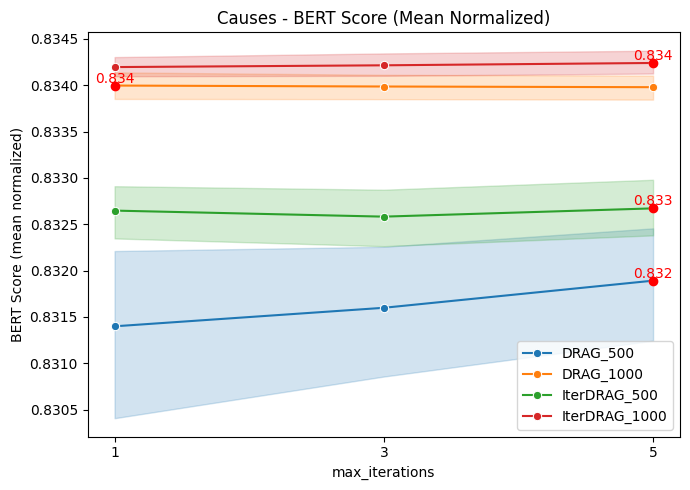

In [22]:
plot_metric_vs_iterations(df[(df["topic"] == "causes")], ['bert_score'])

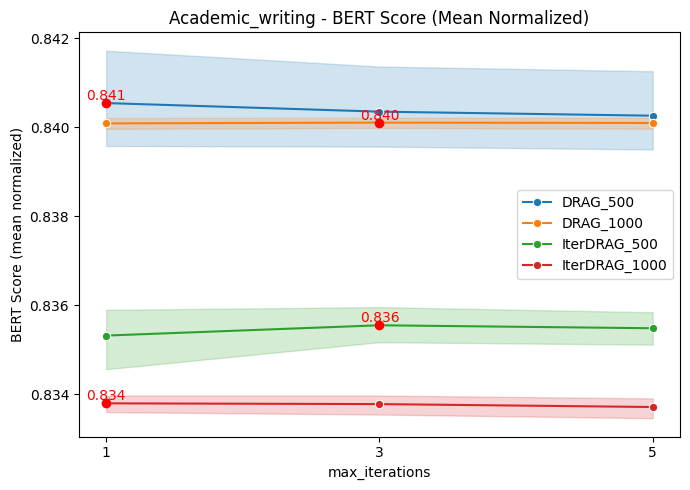

In [23]:
plot_metric_vs_iterations(df[(df["topic"] == "academic_writing")], ['bert_score'])

### #Shots vs. #Docs

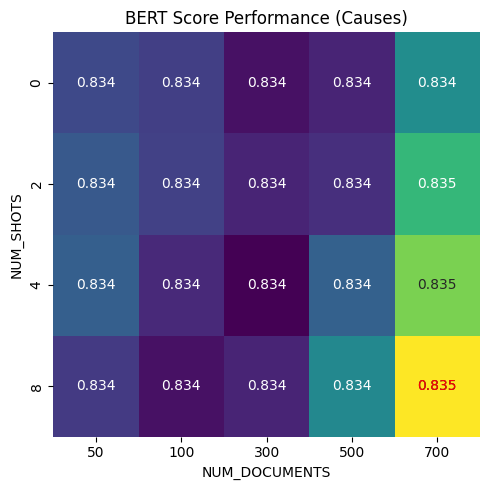

In [31]:
plot_performance_shot_document(df[(df["topic"] == "causes") & (df['rag_type'] == 'IterDRAG') & (df["chunk_size"] == 1000) & (df['max_iterations'] == 5)], ['bert_score'], "Causes")

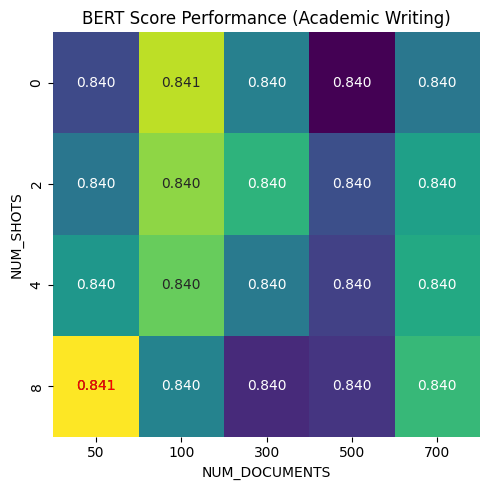

In [32]:
plot_performance_shot_document(df[
    (df["topic"] == "academic_writing") & (df['rag_type'] == 'DRAG') & (df["chunk_size"] == 1000) & (df['max_iterations'] == 1)
    ], ['bert_score'], "Academic Writing"
)

In [276]:
answer_causes = df[
        (df['rag_type'] == 'IterDRAG') &
        (df['topic'] == 'causes') &
        (df['chunk_size'] == 1000) &
        (df['num_shots'] == 8) &
        (df['max_iterations'] == 5) &
        (df['num_documents'] == 700)
]
aa = answer_causes['rag_topic'].values[0]
answer_causes

,rag_type,topic,rag_topic,chunk_size,num_documents,num_shots,max_iterations,exact_match,f1,accuracy,bleu,rouge_l,meteor,bert_score,confidence,context_length
441,IterDRAG,causes,Causes - IterDRAG,1000,700,8,5,0.0,0.208522,0.0,0.000659,0.097228,0.063143,0.835036,1.08324,3878.4


## Large

### # of Iterations

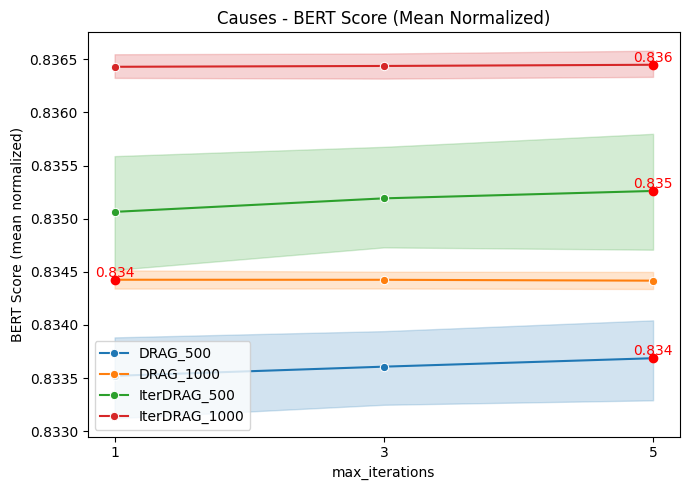

In [18]:
plot_metric_vs_iterations(df_large[(df_large["topic"] == "causes")], ['bert_score'])
# plot_metric_vs_iterations(df_large[(df_large["topic"] == "causes")], METRICS.keys())

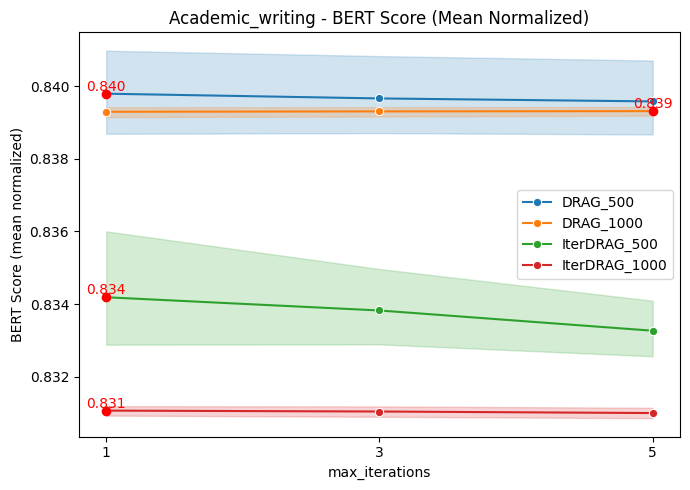

In [19]:
plot_metric_vs_iterations(df_large[(df_large["topic"] == "academic_writing")], ['bert_score'])
# plot_metric_vs_iterations(df_large[(df_large["topic"] == "academic_writing")], METRICS.keys())

### #Shots vs. #Docs

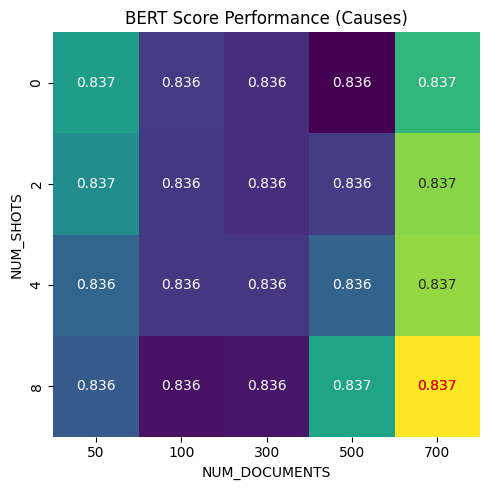

In [27]:
plot_performance_shot_document(df_large[(df_large['rag_type'] == 'IterDRAG') & (df_large["topic"] == "causes") & (df_large["chunk_size"] == 1000) & (df_large['max_iterations'] == 5)], ['bert_score'], "Causes")

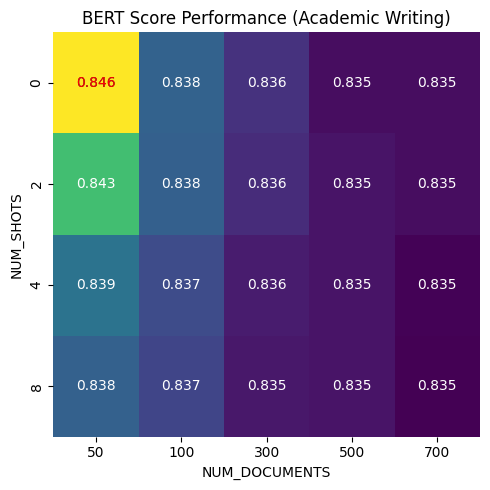

In [21]:
plot_performance_shot_document(df_large[(df_large["topic"] == "academic_writing") & (df_large["chunk_size"] == 500) & (df_large['max_iterations'] == 1)], ['bert_score'], "Academic Writing")